## 1. Data source: Sleep-Accel (PhysioNet; Apple Watch + PSG)

**Dataset:** *Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography* (PhysioNet, v1.0.0)

- **PhysioNet dataset page (download + description):**   
    - https://physionet.org/content/sleep-accel/1.0.0/   
- **DOI (v1.0.0):**   
    - https://doi.org/10.13026/hmhs-py35   
- **Local path (expected):** download + unzip into `./data/sleep_accel/` (the `data/` directory is not committed to git)   
    - expected: `heart_rate/`, `motion/`, `labels/`, `steps/`, plus `LICENSE.txt`   
- **License (for files):** Open Data Commons Attribution License v1.0 (**ODC-By 1.0**)   

**Citations (as requested by PhysioNet):**   
- Walch, O. (2019). *Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography* (version 1.0.0). PhysioNet. https://doi.org/10.13026/hmhs-py35   
- Walch, O., Huang, Y., Forger, D., Goldstein, C. (2019). *Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device*. SLEEP. https://doi.org/10.1093/sleep/zsz180   
- Goldberger, A. L., et al. (2000). *PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals*. Circulation.   


**Files used(and expected columns)**   

We will use the following folders/files from the PhysioNet release:   

- **Motion (ACC):** `motion/[subject]_acceleration.txt`  
  Columns per line: `t_sec, ax_g, ay_g, az_g`  
  where `t_sec` is seconds since PSG start, and accelerations are in **g**.   

- **Heart rate (HR):** `heart_rate/[subject]_heartrate.txt`  
  Columns per line: `t_sec, hr_bpm`  
  where `hr_bpm` is heart rate in **beats per minute**.   

- **PSG sleep labels:** `labels/[subject]_labeled_sleep.txt`  
  Columns per line: `t_sec, stage` with stage codes:  
  `Wake=0, N1=1, N2=2, N3=3, REM=5` (we drop unscored/invalid epochs if present).

> Note: The dataset also includes `steps/` files, but we won’t use them in the first version.


**Notebook intention**

Goal: build a **reproducible sleep-staging pipeline** from **wrist ACC + HR** aligned to **PSG-scored 30-second epochs**, with **leakage-aware, subject-wise evaluation**.

What we do:   

1. **Define the modeling unit as the PSG epoch (30s)** and build one feature row per epoch.  
2. **Align** wrist **ACC** and **HR** to each labeled 30s epoch (aggregate samples falling in `[t, t+30s)`), and attach the PSG stage label at `t`.  
3. **Extract simple, readable features** per epoch:   
   - ACC: magnitude and axis statistics + activity intensity proxies  
   - HR: summary statistics + missingness indicators  
4. Add **causal context (history) features** using past-only rolling summaries over recent epochs (e.g., last few minutes) to capture local sleep continuity without using future information.  
5. Train and compare a small set of classical models using **subject-wise cross-validation** (GroupKFold) and report robust staging metrics (macro-F1, balanced accuracy, confusion matrices, per-subject performance).  
6. Apply a lightweight **temporal stabilization** step (e.g., hysteresis / causal smoothing of probabilities) to reduce one-epoch “blips” and reflect product-realistic output stability.

Note on extra “pre-PSG” wearable data:

This dataset includes wearable streams that may start **before PSG time zero** (e.g., steps for days prior, HR for hours prior, motion shortly before). For the main staging pipeline we **restrict to the PSG-labeled interval** and only aggregate sensor data within labeled 30s epochs. Pre-PSG data can be used in extensions as **subject-level context** (e.g., prior-days activity summaries computed strictly from `t < 0`), but coverage varies across subjects and adds preprocessing complexity.


## 2. Data loading and check

We load per-subject **wrist accelerometer (ACC)**, **heart rate (HR)**, and **PSG sleep labels** from the PhysioNet Sleep-Accel folder structure.

Key conventions:
- All timestamps are de-identified and expressed as **seconds since PSG start** (`t=0` is the PSG start time).
- For the main staging pipeline, we **restrict to the PSG-labeled interval** and only aggregate sensor samples that fall inside each labeled 30s epoch.


In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd

STAGE_MAP = {
    0: "Wake",
    1: "N1",
    2: "N2",
    3: "N3",
    5: "REM",
}

# --- Paths ---
DATA_DIR   = Path("../data/sleep_accel")
MOTION_DIR = DATA_DIR / "motion"
HR_DIR     = DATA_DIR / "heart_rate"
LABEL_DIR  = DATA_DIR / "labels"

for d in [DATA_DIR, MOTION_DIR, HR_DIR, LABEL_DIR]:
    assert d.exists(), f"Missing: {d}"

# --- Subject discovery (use labels as the "source of truth") ---
label_files = sorted(LABEL_DIR.glob("*_labeled_sleep.txt"))
assert len(label_files) > 0, f"No label files found in: {LABEL_DIR}"

SUBJECT_IDS = [re.match(r"(\d+)_labeled_sleep\.txt", f.name).group(1) for f in label_files]
print(f"Found {len(SUBJECT_IDS)} subjects (from labels/). Example IDs: {SUBJECT_IDS[:5]}")

# --- Loaders ---
def load_labels(subject_id: str) -> pd.DataFrame:
    """Load PSG sleep labels: columns [t_sec, stage]."""
    path = LABEL_DIR / f"{subject_id}_labeled_sleep.txt"
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["t_sec", "stage"])
    df["subject_id"] = subject_id
    df["t_sec"] = df["t_sec"].astype(float)
    df["stage"] = df["stage"].astype(int)
    df = df.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
    return df

def load_hr(subject_id: str) -> pd.DataFrame:
    """Load Apple Watch HR: columns [t_sec, hr_bpm]."""
    path = HR_DIR / f"{subject_id}_heartrate.txt"
    df = pd.read_csv(path, sep=",", header=None, names=["t_sec", "hr_bpm"])
    df["subject_id"] = subject_id
    df["t_sec"] = df["t_sec"].astype(float)
    df["hr_bpm"] = df["hr_bpm"].astype(float)
    df = df.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
    return df

def load_acc(subject_id: str) -> pd.DataFrame:
    """Load Apple Watch accelerometer: columns [t_sec, ax_g, ay_g, az_g]."""
    path = MOTION_DIR / f"{subject_id}_acceleration.txt"
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["t_sec", "ax_g", "ay_g", "az_g"])
    df["subject_id"] = subject_id
    df["t_sec"] = df["t_sec"].astype(float)
    for c in ["ax_g", "ay_g", "az_g"]:
        df[c] = df[c].astype(float)
    df = df.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
    return df

# --- Quick sanity check on one subject ---
sid = SUBJECT_IDS[0]

labels = load_labels(sid)
hr     = load_hr(sid)
acc    = load_acc(sid)

print(f"\nSubject {sid} loaded:")
print(f"  labels: {labels.shape} | t range: [{labels.t_sec.min():.1f}, {labels.t_sec.max():.1f}]")
print(f"  hr    : {hr.shape}     | t range: [{hr.t_sec.min():.1f}, {hr.t_sec.max():.1f}]")
print(f"  acc   : {acc.shape}    | t range: [{acc.t_sec.min():.1f}, {acc.t_sec.max():.1f}]")

print("\nLabel codes present (counts):")
print(labels["stage"].value_counts().sort_index())

# Show a small peek
label_counts = labels["stage"].value_counts().sort_index()
display(pd.DataFrame({
    "stage_code": label_counts.index,
    "stage_name": [STAGE_MAP.get(int(s), "OTHER") for s in label_counts.index],
    "count": label_counts.values,
}))

Found 31 subjects (from labels/). Example IDs: ['1066528', '1360686', '1449548', '1455390', '1818471']

Subject 1066528 loaded:
  labels: (952, 3) | t range: [0.0, 28530.0]
  hr    : (16617, 3)     | t range: [-355241.7, 34491.2]
  acc   : (1281000, 5)    | t range: [-21684.8, 28626.5]

Label codes present (counts):
stage
0    185
1     97
2    299
3     62
5    309
Name: count, dtype: int64


,stage_code,stage_name,count
0,0,Wake,185
1,1,N1,97
2,2,N2,299
3,3,N3,62
4,5,REM,309


## 3. Epoch alignment (30s) — assign raw samples to PSG epochs

We use PSG labels as the **epoch grid** (30s cadence), and assign raw HR and ACC samples to each epoch.

Output: one row per epoch with:  
- `epoch_id`, `t_start_sec`, `t_end_sec`, `stage_code`  
- raw per-epoch sequences: HR (`t_sec`, `hr_bpm`) and ACC (`t_sec`, `ax_g`, `ay_g`, `az_g`)  

**Note on sampling rates and interpolation:**  
ACC is high-rate, HR is sparse/irregular, and labels are per 30s epoch. We **do not resample or interpolate** signals to a common grid. Instead, we compute **per-epoch summary features** (e.g. counts, mean/std/percentiles, simple trends) directly from the raw samples assigned to each epoch at the next section.

In [3]:
EPOCH_SEC = 30

# --- sort for safety (merge_asof requires sorted keys) ---
labels_s = labels.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
hr_s     = hr.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
acc_s    = acc.sort_values("t_sec", kind="mergesort").reset_index(drop=True)

# --- epoch grid from labels (PSG epochs) ---
epochs = (
    labels_s.loc[labels_s["stage"].isin(STAGE_MAP.keys()), ["subject_id", "t_sec", "stage"]]
    .rename(columns={"t_sec": "t_start_sec", "stage": "stage_code"})
    .reset_index(drop=True)
)
epochs["t_end_sec"] = epochs["t_start_sec"] + EPOCH_SEC
epochs["epoch_id"] = epochs.index.astype(int)

# --- HR: assign each sample to the latest epoch start (backward), then keep only within [start, end) ---
hr_join = pd.merge_asof(
    hr_s, epochs[["subject_id", "t_start_sec", "t_end_sec", "epoch_id"]],
    left_on="t_sec", right_on="t_start_sec",
    by="subject_id",
    direction="backward",
)
# Keep only samples that truly fall inside the assigned epoch window [t_start, t_end)
hr_join = hr_join[hr_join["t_sec"] < hr_join["t_end_sec"]]

hr_raw = (
    hr_join.groupby(["subject_id", "epoch_id"], sort=True)[["t_sec", "hr_bpm"]]
    .apply(lambda g: pd.Series({
        "hr_t_sec": g["t_sec"].to_numpy(),
        "hr_bpm":  g["hr_bpm"].to_numpy(),
    }))
    .reset_index()
)

# --- ACC: same assignment ---
acc_join = pd.merge_asof(
    acc_s, epochs[["subject_id", "t_start_sec", "t_end_sec", "epoch_id"]],
    left_on="t_sec", right_on="t_start_sec",
    by="subject_id",
    direction="backward",
)
acc_join = acc_join[acc_join["t_sec"] < acc_join["t_end_sec"]]

acc_raw = (
    acc_join.groupby(["subject_id", "epoch_id"], sort=True)[["t_sec", "ax_g", "ay_g", "az_g"]]
    .apply(lambda g: pd.Series({
        "acc_t_sec": g["t_sec"].to_numpy(),
        "acc_x":     g["ax_g"].to_numpy(),
        "acc_y":     g["ay_g"].to_numpy(),
        "acc_z":     g["az_g"].to_numpy(),
    }))
    .reset_index()
)

# --- epoch table with raw sequences (no features yet) ---
epoch_raw = (
    epochs.merge(hr_raw, on=["subject_id", "epoch_id"], how="left")
          .merge(acc_raw, on=["subject_id", "epoch_id"], how="left")
)

print("epoch_raw:", epoch_raw.shape)
display(epoch_raw.head())


epoch_raw: (952, 11)


,subject_id,t_start_sec,stage_code,t_end_sec,epoch_id,hr_t_sec,hr_bpm,acc_t_sec,acc_x,acc_y,acc_z
0,1066528,0.0,0,30.0,0,"[6.38561010361, 6.38561010361, 6.38561010361, ...","[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 51.0, 51....","[0.0159480571747, 0.0360059738159, 0.055885076...","[0.4039307, 0.4039154, 0.4049072, 0.4083557, 0...","[0.4490051, 0.4480286, 0.4465485, 0.447525, 0....","[-0.7968597, -0.7953949, -0.7958527, -0.796768..."
1,1066528,30.0,0,60.0,1,"[33.3856399059, 33.3856399059, 33.3856399059, ...","[54.0, 54.0, 54.0, 53.0, 53.0, 53.0, 50.0, 50....","[30.0175080299, 30.0375330448, 30.0574300289, ...","[0.401886, 0.4028931, 0.4028931, 0.4019012, 0....","[0.4564209, 0.4588623, 0.4578857, 0.4573975, 0...","[-0.7906189, -0.7935486, -0.7925568, -0.792083..."
2,1066528,60.0,0,90.0,2,"[64.3856399059, 64.3856399059, 64.3856399059, ...","[50.0, 50.0, 50.0, 52.0, 52.0, 52.0, 53.0, 53....","[60.0183210373, 60.0382120609, 60.058177948, 6...","[0.4048615, 0.4053497, 0.4043732, 0.4043884, 0...","[0.4554291, 0.4554291, 0.4569092, 0.4573822, 0...","[-0.7920227, -0.792511, -0.7925262, -0.7944794..."
3,1066528,90.0,0,120.0,3,"[91.3856399059, 91.3856399059, 91.3856399059, ...","[54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54....","[90.0176670551, 90.0374310017, 90.0576291084, ...","[0.4013367, 0.3989563, 0.3989258, 0.4008484, 0...","[0.4633331, 0.4623108, 0.4687195, 0.4623413, 0...","[-0.7853241, -0.7936401, -0.791748, -0.7858124..."
4,1066528,120.0,0,150.0,4,"[122.385639906, 122.385639906, 122.385639906, ...","[56.0, 56.0, 56.0, 57.0, 57.0, 57.0, 57.0, 57....","[120.016488075, 120.036480904, 120.056406975, ...","[0.3984222, 0.4008636, 0.39888, 0.4003754, 0.3...","[0.4662628, 0.4662781, 0.4662781, 0.4672546, 0...","[-0.7907562, -0.7882843, -0.78685, -0.7878113,..."


Example plot for one epoch: subject_id=1066528 | epoch_id=50 | window=[1500.0,1530.0) | stage=N1


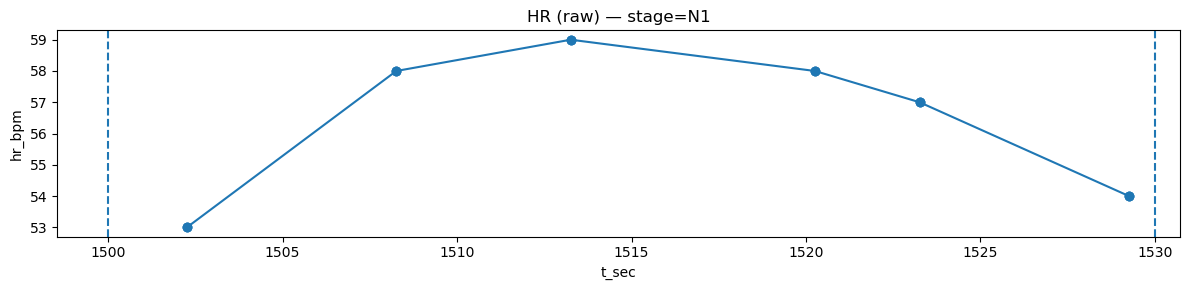

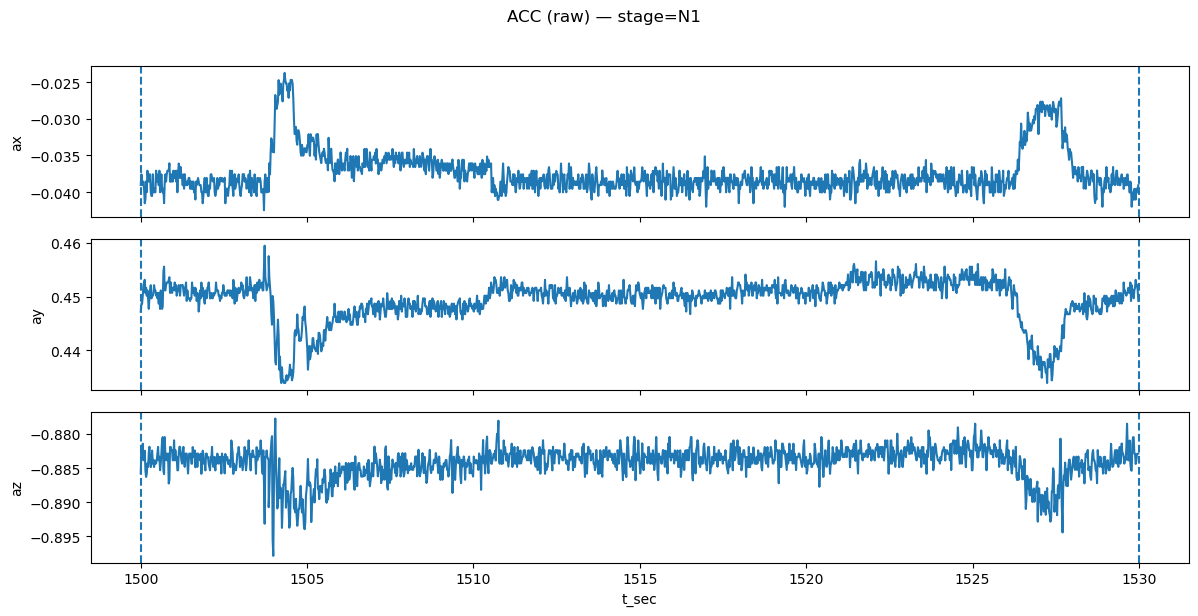

In [4]:
import matplotlib.pyplot as plt

# Choose a stage code to visualize:
# 0=Wake, 1=N1, 2=N2, 3=N3, 5=REM  (see STAGE_MAP)
TARGET_STAGE_CODE = 1

# First epoch (in the current subject) matching that stage
idx = epoch_raw.index[epoch_raw["stage_code"] == TARGET_STAGE_CODE][0]
row = epoch_raw.loc[idx]

t0, t1 = row["t_start_sec"], row["t_end_sec"]
print(f"Example plot for one epoch: subject_id={row['subject_id']} | epoch_id={int(row['epoch_id'])} | window=[{t0},{t1}) | stage={STAGE_MAP.get(int(row['stage_code']), row['stage_code'])}")

# HR (raw)
plt.figure(figsize=(12, 3))
if isinstance(row.get("hr_t_sec"), np.ndarray):
    plt.plot(row["hr_t_sec"], row["hr_bpm"], marker="o")
plt.axvline(t0, linestyle="--"); plt.axvline(t1, linestyle="--")
plt.title(f"HR (raw) — stage={STAGE_MAP.get(TARGET_STAGE_CODE, TARGET_STAGE_CODE)}")
plt.xlabel("t_sec"); plt.ylabel("hr_bpm")
plt.tight_layout()
plt.show()

# ACC (raw) — 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for ax, col, name in zip(axes, ["acc_x", "acc_y", "acc_z"], ["ax", "ay", "az"]):
    if isinstance(row.get("acc_t_sec"), np.ndarray):
        ax.plot(row["acc_t_sec"], row[col])
    ax.axvline(t0, linestyle="--"); ax.axvline(t1, linestyle="--")
    ax.set_ylabel(name)

axes[-1].set_xlabel("t_sec")
fig.suptitle(f"ACC (raw) — stage={STAGE_MAP.get(TARGET_STAGE_CODE, TARGET_STAGE_CODE)}", y=1.02)
plt.tight_layout()
plt.show()


## 4. Feature extraction (per epoch)

We convert each PSG-aligned 30-second epoch into a single feature vector.  
To keep the notebook **simple and robust** (and to avoid a “feature zoo”, especially once we add **causal history features**), we use a **small, standard set of summary statistics**.

**Signals and features**

**Accelerometer (ACC):**   
- We collapse tri-axial ACC into **magnitude** `|a| = sqrt(ax² + ay² + az²)`.   
- Per epoch, we compute:   
  - `acc_mag_median` (central level)   
  - `acc_mag_iqr` (variability)   
  - `acc_mag_count` (QC: number of samples in the epoch)   

**Heart rate (HR):**   
- Per epoch, we compute:   
  - `hr_mean` (central level)   
  - `hr_iqr` (within-epoch variability)   
  - `hr_count` (QC: number of samples in the epoch)   

**Note on sampling and reliability**
ACC is high-rate while HR is sparse/irregular; labels are per 30s epoch. We **do not resample or interpolate**.  
Summary statistics are computed directly from the raw samples assigned to each epoch, and `*_count` acts as a lightweight **signal reliability** indicator (few/no samples → less reliable features).


In [15]:
# --- Start from the epoch table (one row per 30s PSG epoch) ---
epoch_features = epoch_raw[["subject_id", "epoch_id", "t_start_sec", "t_end_sec", "stage_code"]].copy()

# --- HR features (per-epoch arrays -> scalar summaries) ---
# hr_bpm is stored as an array in each row
# treat missing (NaN) as empty
hr_mean  = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).mean()) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_iqr   = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).quantile(0.75) - pd.Series(a).quantile(0.25)) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_count = epoch_raw["hr_bpm"].apply(lambda a: int(a.size) if isinstance(a, np.ndarray) else 0)

epoch_features["hr_mean"]  = hr_mean
epoch_features["hr_iqr"]   = hr_iqr
epoch_features["hr_count"] = hr_count

# --- ACC magnitude features (x/y/z arrays -> magnitude array -> scalar summaries) ---
# Compute magnitude per epoch, then summarize
acc_mag = epoch_raw.apply(
    lambda r: np.sqrt(r["acc_x"]**2 + r["acc_y"]**2 + r["acc_z"]**2)
    if isinstance(r["acc_x"], np.ndarray) else np.array([], dtype=float),
    axis=1
)

acc_mag_median = acc_mag.apply(lambda a: float(pd.Series(a).median()) if len(a) else np.nan)
acc_mag_iqr    = acc_mag.apply(lambda a: float(pd.Series(a).quantile(0.75) - pd.Series(a).quantile(0.25)) if len(a) else np.nan)
acc_mag_count  = acc_mag.apply(lambda a: int(len(a)) if len(a) else 0)

epoch_features["acc_mag_median"] = acc_mag_median
epoch_features["acc_mag_iqr"]    = acc_mag_iqr
epoch_features["acc_mag_count"]  = acc_mag_count

print("epoch_features shape:", epoch_features.shape)
display(epoch_features.head())


epoch_features shape: (952, 11)


,subject_id,epoch_id,t_start_sec,t_end_sec,stage_code,hr_mean,hr_iqr,hr_count,acc_mag_median,acc_mag_iqr,acc_mag_count
0,1066528,0,0.0,30.0,0,52.166667,0.0,18,1.000037,0.002023,1500
1,1066528,1,30.0,60.0,0,50.833333,4.0,18,1.000051,0.001958,1500
2,1066528,2,60.0,90.0,0,52.400000,1.0,15,1.000138,0.002042,1500
3,1066528,3,90.0,120.0,0,53.833333,0.0,18,1.000022,0.002433,1500
4,1066528,4,120.0,150.0,0,60.500000,8.0,18,0.999941,0.002323,1500
